<a href="https://colab.research.google.com/github/IgorTrevelin/Detecting-Spam-in-SMS-Messages/blob/main/Detecting_Spam_in_SMS_Messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💬 Detecting Spam in SMS Messages 💬

[![LinkedIn](https://img.shields.io/badge/LinkedIn-igor--trevelin-blue)](https://www.linkedin.com/in/igor-trevelin/)
[![GitHub](https://img.shields.io/badge/GitHub-IgorTrevelin-purple)](https://github.com/IgorTrevelin)

![image](https://storage.googleapis.com/kaggle-datasets-images/483/982/15b24a8964e8d4afadff79a1a5543450/dataset-cover.jpg)

SMS spam detection is a crucial and evolving field aimed at identifying and mitigating the influx of unsolicited and fraudulent text messages sent to mobile users. By employing sophisticated algorithms and machine learning techniques, SMS spam detection systems analyze the content and metadata of incoming messages to distinguish between legitimate and spam messages. These systems can recognize patterns, keywords, and sender behavior indicative of spam, enabling mobile service providers and users to filter out unwanted messages effectively. As SMS spam tactics become more sophisticated, continuous research and development in this area remain essential to staying one step ahead of spammers and ensuring a seamless and secure mobile messaging experience for users worldwide.

In this project we will build a spam detector using machine learning models and the data from the following [address](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).

# <a id="required"></a>Required Packages

In [ ]:
%%capture
%pip install sentence-transformers pycaret optuna pygad

In [ ]:
# data load and manipulation
import os
import numpy as np
import pandas as pd
import charset_normalizer
import requests

# sentence transformers
from sentence_transformers import SentenceTransformer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

# Natural Language Processing
import re
from nltk.corpus import stopwords
from nltk import download as nltk_download
nltk_download("stopwords")

# dimensionality reduction and machine learning modeling
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.manifold import TSNE
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict
)
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(transform_output="pandas")

# AutoML and model hyperparameter tuning
from pycaret.classification import ClassificationExperiment
import optuna

# model persistence
import pickle

# disable warnings
import warnings
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# set default random seed
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# About the Data

The dataset used in this project contains two valid features:
* `v1`: the SMS message classification (_ham_ for legitimate and _spam_ for spam).
* `v2`: the SMS message content.

The dataset contains 5572 rows, each of them representing a single SMS message.

In [ ]:
# detecting dataset
dataset_url = "https://www.dropbox.com/s/xc9ada8n65i5bdl/spam.csv?dl=1"

# download a file from the web
def download_file(file_url, filename):
    response = requests.get(file_url, allow_redirects=True, verify=False)
    open(filename, "wb").write(response.content)

# try to automatically detect and return file encoding
def get_file_encoding(file, n_bytes=-1):
    with open(file, "rb") as f:
        results = charset_normalizer.detect(f.read(n_bytes))
        return results["encoding"]

download_file(dataset_url, "spam.csv")
encoding = get_file_encoding("spam.csv")
df = pd.read_csv("spam.csv", encoding=encoding)
df = df.loc[:, ["v1", "v2"]]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# get dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
# counting missing values
df.isnull().sum()

v1    0
v2    0
dtype: int64

Great! We don't have missing values in the dataset. Now let's search for duplicated rows.

In [ ]:
# counting duplicates
df.duplicated().sum()

403

We have some duplicated rows in the dataset. Duplicated rows don't add any new information to our analysis and modeling process, so we can just drop them.

In [ ]:
# removing duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(5169, 2)

After removing duplicates, we have 5169 SMS messages to work with.

In [ ]:
# count unique values for each column in the dataset
df.nunique()

v1       2
v2    5169
dtype: int64

# <a id="exploration"></a>Basic Data Exploration

In this step we will get to know better our data. Let's begin with our target variable.

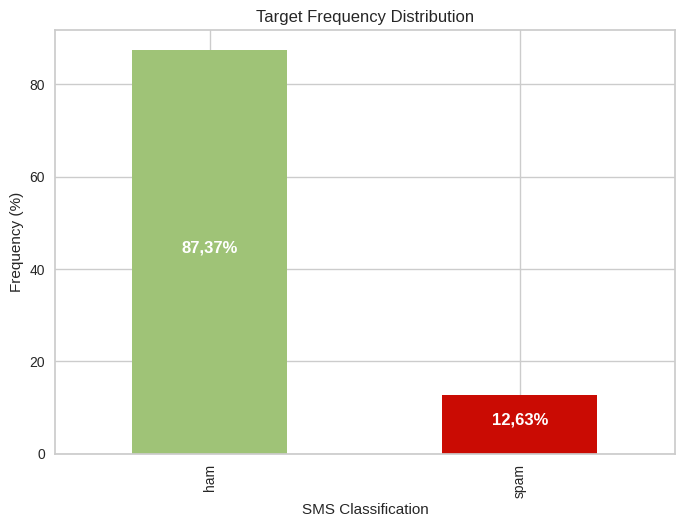

In [ ]:
# looking at the distribution of our target variable
target_freq = round(df["v1"].value_counts(normalize=True) * 100, 2)

ax = target_freq.transpose().plot(
    title="Target Frequency Distribution",
    kind="bar",
    color=['g', 'r'],
    xlabel="SMS Classification",
    ylabel="Frequency (%)"
)

p = ax.patches

for i, c in enumerate(["ham", "spam"]):
  plt.annotate(
      target_freq.loc[c].astype(str).replace('.', ',') + '%',
      xy=(
        p[i].get_x() + p[i].get_width() / 2,
        p[i].get_height() / 2
      ),
      color="white",
      horizontalalignment="center",
      fontweight="semibold"
  )

plt.show()

As we can see, the target variable is unbalanced with only **12,63%** of spam cases. This behavior is very common in problems like these and we will handle this unbalancement in the modeling steps. Now let's give a look at the common words seen in spam messages.

In [ ]:
# remove stop words
def text_preprocess(text):
  stop_words = stopwords.words("english")
  text = re.sub("[^a-zA-Z]", ' ', text)
  words = text.lower().split(' ')
  words = [word for word in words if word not in stop_words]
  return " ".join(words)

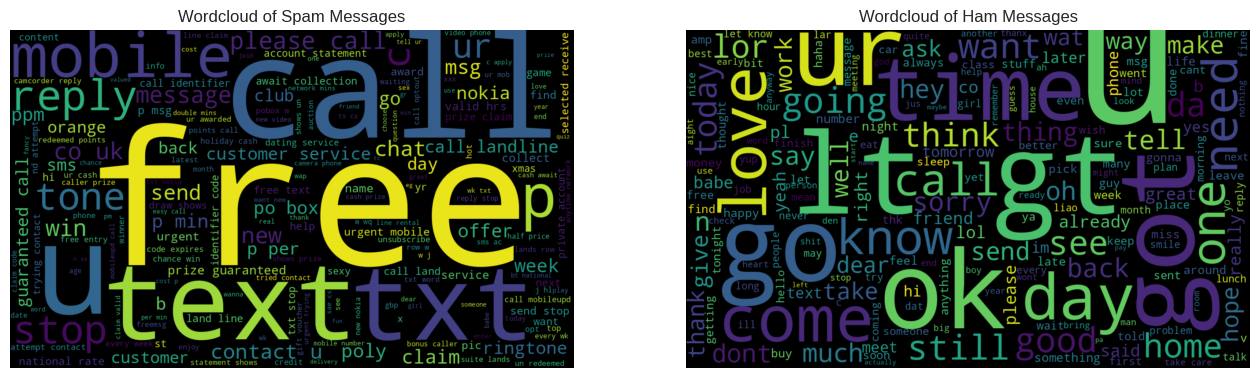

In [ ]:
# plot the most common words in spam and ham sms messages
spam_texts = text_preprocess(" ".join(df[df["v1"] == "spam"]["v2"].to_list()))
ham_texts = text_preprocess(" ".join(df[df["v1"] == "ham"]["v2"].to_list()))

plt.figure(figsize=(16, 5))
plt.subplot(121)
wc = wordcloud.WordCloud(width=1280, height=768).generate(spam_texts)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Spam Messages")

plt.subplot(122)
wc = wordcloud.WordCloud(width=1280, height=768).generate(ham_texts)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Ham Messages")

plt.show()

The monst frequent words from spam SMS messages are pretty different from the legitimate ones. We can observe that the most common words from spams are words usually used for advertising, promotions and free offerings.

In order to use **text data** to train machine learning models, it is necessary to obtain a **numerical representation** of words or sentences, capturing the semantic meaning and contextual information of the text they represent.
When applied to a sentence, this numerical representation is called **sentence embedding** and there are several approaches to generate them.

For the purposes of this project, we will use the python package _sentence-transformers_ to automatically generate the embeddings for us. This package uses encoder models to generate the embeddings. It is a common practice to use pretrained models provided by the package maintainers. And that's what we'll do.

Let's generate the sentence embeddings for the SMS messages texts and try to visualize them with the help of TSNE, a dimensionality reduction algorithm.

In [ ]:
# instantiate the sentence transformer object and download the pretrained encoder all-mpnet-base-v2
sentence_transformer = SentenceTransformer("all-mpnet-base-v2")

In [ ]:
# generating sentence embeddings matrix and outputing its shape
embeddings = sentence_transformer.encode(df["v2"].values, show_progress_bar=False)
print(embeddings.shape)

(5169, 768)


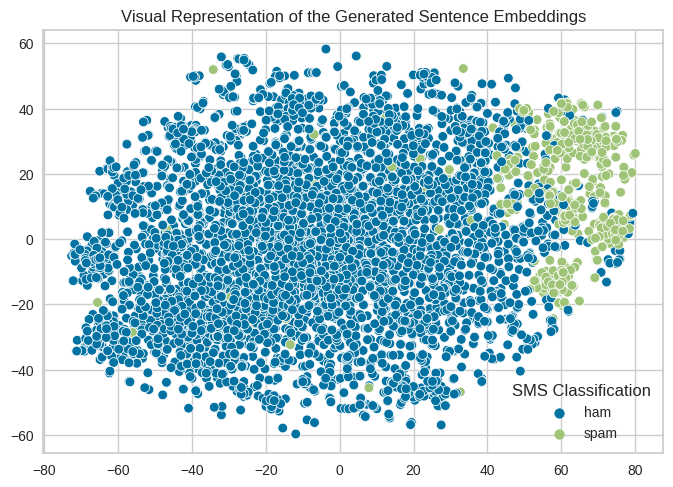

In [ ]:
# visualizing the sentence embeddings in a 2D graph with TSNE
tsne = TSNE(n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(embeddings)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["v1"])
plt.legend(title="SMS Classification")
plt.title("Visual Representation of the Generated Sentence Embeddings")
plt.show()

We got a pretty good visual representation of the sentence embeddings with a good separation of spams and hams. Usually this is a good indication that our machine learning models will have a good performance in the classification task.

# <a id="preprocessing"></a>Preparing Data for Machine Learning

To train machine learning models with _scikit-learn_, the model inputs must be numeric. So we will encode the target feature (_ham_ and _spam_ values) into **0** and **1**, being the last for the spams.

In [ ]:
# reusing the embeddings generated in the steps above
X = df["v2"].to_frame(name="v2").reset_index(drop=True)

# encoding the target feature into 0 and 1s
y = df["v1"].map({
    "ham": 0,
    "spam": 1
}).reset_index(drop=True)

Now we'll transform the SMS message texts into sentence embeddings.

In [ ]:
# custom transformer class that transforms the sms text into sentence embeddings
class SMSSentenceTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.sentence_transformer = SentenceTransformer("all-mpnet-base-v2")

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X_new = X.copy()
    embeddings = self.sentence_transformer.encode(X_new["v2"].values, show_progress_bar=False)
    X_new[[f"e{i}" for i in range(embeddings.shape[1])]] = embeddings
    X_new.drop("v2", axis=1, inplace=True)

    return X_new

sentence_transformer = SMSSentenceTransformer()
X_transformed = sentence_transformer.fit_transform(X)

The goal of every machine learning project is to build a solution that works with unseen data. In order to achieve this, we need to evaluate our model performance using data that is not used in its training process. So we'll split our dataset into train and test datasets. The test dataset must keep untouched untill the last steps of this project, and will be used to evaluate our model performance.

In [ ]:
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, stratify=y, test_size=0.25, random_state=SEED)

# <a id="modelin"></a>Modeling

In the modeling step we'll start by running an AutoML experiment and use its results as a **baseline**. In our experiments, we will consider the F1 score metric to select the best models.

The F1 score provides a single value combining the **precision** and **recall** of a model, and it is particularly useful in scenarios with imbalancement between classes. Its formula is as follows:

$${F1} = \dfrac{2 * (Precision * Recall)}{Precision + Recall}$$



In [ ]:
# concatenate X and y to use within PyCaret AutoML
data = pd.concat((X_train, y_train), axis=1)

# run AutoML experiment
automl = ClassificationExperiment()
automl.setup(
    data,
    target="v1",
    n_jobs=-1,
    train_size=0.75,
    session_id=SEED
)

# run the experiment and return the top 3 models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
best_models = automl.compare_models(sort="F1", fold=cv, n_select=3)

,Description,Value
0,Session id,42
1,Target,v1
2,Target type,Binary
3,Original data shape,"(3876, 769)"
4,Transformed data shape,"(3876, 769)"
5,Transformed train set shape,"(2907, 769)"
6,Transformed test set shape,"(969, 769)"
7,Numeric features,768
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9849,0.9916,0.9075,0.9713,0.9378,0.9292,0.9302,0.2720
svm,SVM - Linear Kernel,0.9842,0.0000,0.9129,0.9614,0.9360,0.9269,0.9277,0.2040
ridge,Ridge Classifier,0.9845,0.0000,0.8940,0.9824,0.9357,0.9269,0.9285,0.3480
lr,Logistic Regression,0.9783,0.9946,0.8425,0.9846,0.9074,0.8952,0.8991,1.7380
knn,K Neighbors Classifier,0.9745,0.9820,0.9484,0.8661,0.9046,0.8900,0.8917,0.4680
xgboost,Extreme Gradient Boosting,0.9766,0.9900,0.8369,0.9749,0.9002,0.8871,0.8907,0.6720
ada,Ada Boost Classifier,0.9728,0.9874,0.8588,0.9214,0.8888,0.8733,0.8742,0.3600
lightgbm,Light Gradient Boosting Machine,0.9735,0.9909,0.8098,0.9776,0.8853,0.8705,0.8757,0.7860
nb,Naive Bayes,0.9694,0.9828,0.8670,0.8896,0.8775,0.8600,0.8605,0.2920
gbc,Gradient Boosting Classifier,0.9687,0.9855,0.7691,0.9788,0.8607,0.8434,0.8516,0.3560


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

The top 3 models in our AutoML experiment were a **Linear Discriminant Analysis**, a **SVM** with linear kernel and a **Ridge Classifier**. In the next steps, we will try to improve their performances applying parameter hypertuning.

First we will define a model evaluation procedure to equally compare each built model. The following steps will be followed:
* Make **cross-validated predictions** of the training set.
* **Fit** the model with the training set and make **predictions of the test set**.
* Calculate `Accuracy`, `Precision`, `Recall`, `F1 Score` and `ROC AUC` for train and test sets using the previously made predictions and output the results.
* Output the **confusion matrix** for both train and test sets.

We will run this procedure with each one of the 3 models mentioned above, before and after the hyperparameter tuning.

After all these experiments we'll build a comparison table with the models performances in the test dataset to select the best one.

In [ ]:
# function to calculate model train/test performance metrics
def evaluate_model(model, X_train, y_train, X_test, y_test, cv):
  # make a copy of the model
  model = clone(model)

  # make cross-validated predictions on the train set
  train_preds = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)

  # calculate train scores to calculate the train ROC AUC
  if hasattr(model, "decision_function"):
    train_scores = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1, method="decision_function")
  else:
    train_scores = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1, method="predict_proba")[:, 1]

  # fit the model with train data
  model.fit(X_train, y_train)

  # make predictions on the test set
  test_preds = model.predict(X_test)

  # calculate test scores to calculate the test ROC AUC
  if hasattr(model, "decision_function"):
    test_scores = model.decision_function(X_test)
  else:
    test_scores = model.predict_proba(X_test)

  # calculate train metrics
  train_accuracy = accuracy_score(y_train, train_preds)
  train_precision = precision_score(y_train, train_preds)
  train_recall = recall_score(y_train, train_preds)
  train_f1 = f1_score(y_train, train_preds)
  train_roc = roc_auc_score(y_train, train_scores)

  # calculate test metrics
  test_accuracy = accuracy_score(y_test, test_preds)
  test_precision = precision_score(y_test, test_preds)
  test_recall = recall_score(y_test, test_preds)
  test_f1 = f1_score(y_test, test_preds)
  test_roc = roc_auc_score(y_test, test_scores)

  # bring toghether metrics within a dataframe
  metrics_df = pd.DataFrame(data={
      "Accuracy": (train_accuracy, test_accuracy),
      "Precision": (train_precision, test_precision),
      "Recall": (train_recall, test_recall),
      "F1 Score": (train_f1, test_f1),
      "ROC AUC": (train_roc, test_roc)
  }, index=("Train", "Test"))

  # plot the train and test confusion matrixes
  plt.figure(figsize=(16, 4))
  ax = plt.subplot(121)
  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, ax=ax)
  plt.grid(False)

  ax = plt.subplot(122)
  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax=ax)
  plt.grid(False)
  plt.show()

  print(metrics_df)

### Linear Discriminant Analysis (LDA)

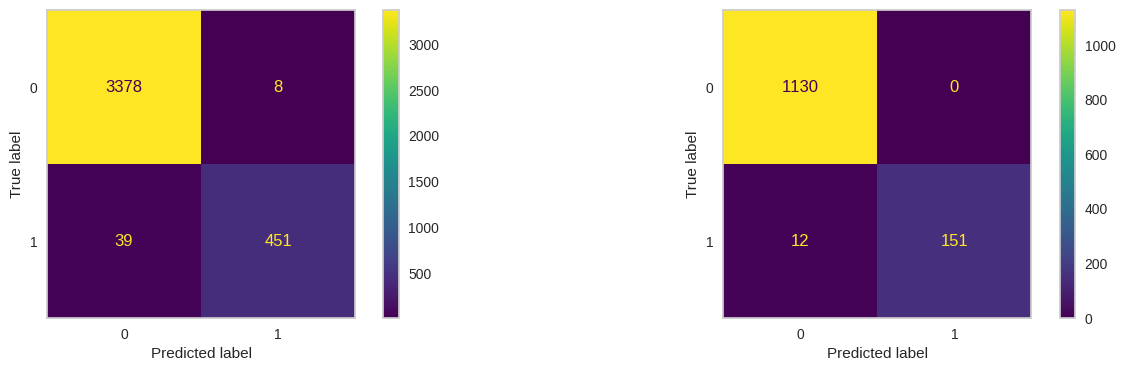

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.987874   0.982571  0.920408  0.950474  0.992604
Test   0.990719   1.000000  0.926380  0.961783  0.998388


In [ ]:
# running evaluation procedure on the AutoML LDA model
lda = clone(best_models[0])
evaluate_model(lda, X_train, y_train, X_test, y_test, cv=cv)

In [ ]:
# objective function for LDA tuning
def lda_objective(trial):
  solver = trial.suggest_categorical("solver", ["lsqr", "eigen"])
  shrinkage = trial.suggest_float("shrinkage", 0.0, 1.0)
  lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)

  # make cross-validated predictions
  preds = cross_val_predict(lda, X_train, y_train, cv=cv, n_jobs=-1)

  # return cross-validated f1 score
  return f1_score(y_train, preds)

# run optuna optimization
lda_study = optuna.create_study(direction='maximize')
lda_study.optimize(lda_objective, n_trials=100)

[I 2023-07-25 13:45:38,812] A new study created in memory with name: no-name-08695101-c807-405a-8df0-480371c3120e
[I 2023-07-25 13:45:42,009] Trial 0 finished with value: 0.9558823529411765 and parameters: {'solver': 'lsqr', 'shrinkage': 0.3182219931167566}. Best is trial 0 with value: 0.9558823529411765.
[I 2023-07-25 13:45:45,537] Trial 1 finished with value: 0.9382716049382717 and parameters: {'solver': 'eigen', 'shrinkage': 0.8263631127798106}. Best is trial 0 with value: 0.9558823529411765.
[I 2023-07-25 13:45:50,395] Trial 2 finished with value: 0.9534883720930233 and parameters: {'solver': 'lsqr', 'shrinkage': 0.06527303945407781}. Best is trial 0 with value: 0.9558823529411765.
[I 2023-07-25 13:45:55,042] Trial 3 finished with value: 0.9371781668383111 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7988950815613969}. Best is trial 0 with value: 0.9558823529411765.
[I 2023-07-25 13:45:58,559] Trial 4 finished with value: 0.9545934530095036 and parameters: {'solver': 'eigen', 

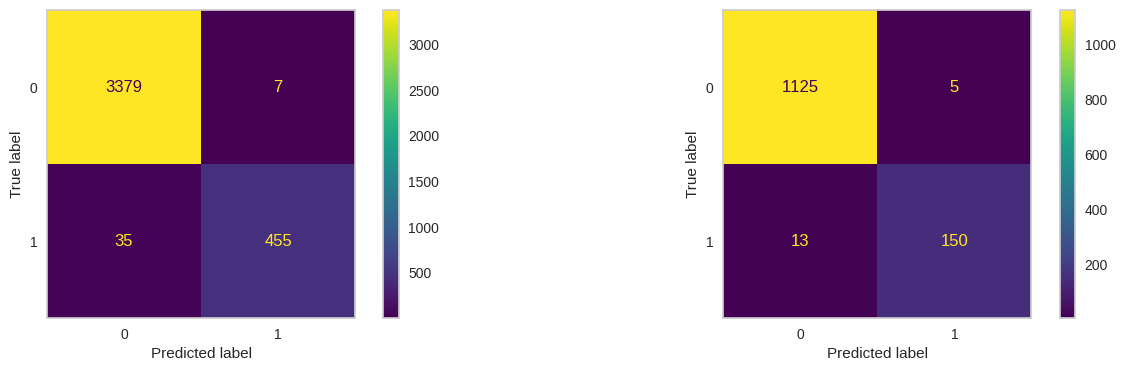

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.989164   0.984848  0.928571  0.955882  0.993101
Test   0.986079   0.967742  0.920245  0.943396  0.997975


In [ ]:
# build model with optimized hyperparameters and run evaluation procedure
lda_tuned = LinearDiscriminantAnalysis(**lda_study.best_params)
evaluate_model(lda_tuned, X_train, y_train, X_test, y_test, cv=cv)

### SVM Linear (SGD)

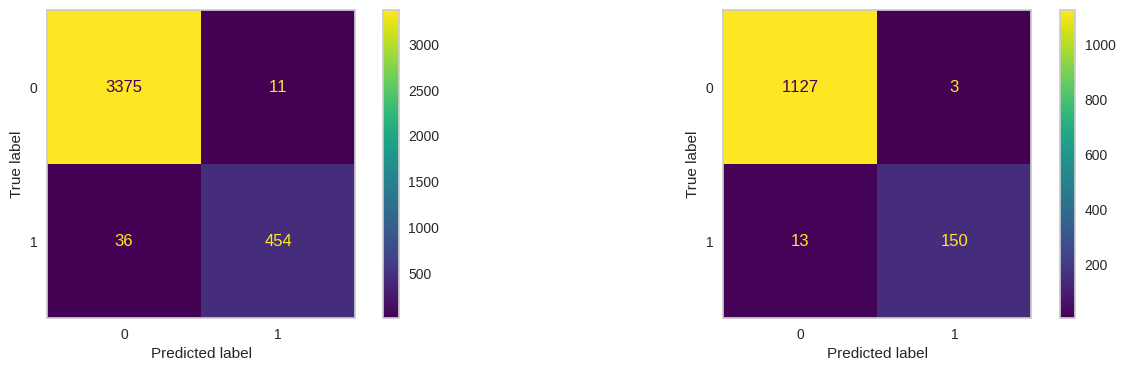

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.987874   0.976344  0.926531  0.950785  0.994572
Test   0.987626   0.980392  0.920245  0.949367  0.997443


In [ ]:
# run evaluation procedure for the AutoML SGD model
sgd = clone(best_models[1])
evaluate_model(sgd, X_train, y_train, X_test, y_test, cv=cv)

In [ ]:
# define objective function for SGD hyperparameter optimization
def sgd_objective(trial):
  alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
  l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
  max_iter = trial.suggest_int("max_iter", 100, 5000)
  sgd = SGDClassifier(loss="hinge", alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, random_state=SEED)

  # make cross-validated predictions
  preds = cross_val_predict(sgd, X_train, y_train, cv=cv, n_jobs=-1)

  # return cross-validated f1 score
  return f1_score(y_train, preds)

# run optuna optimization
sgd_study = optuna.create_study(direction="maximize")
sgd_study.optimize(sgd_objective, n_trials=100)

[I 2023-07-25 13:52:40,526] A new study created in memory with name: no-name-5a1f50d2-4a15-49db-836c-8cf207cf9b84
[I 2023-07-25 13:52:41,461] Trial 0 finished with value: 0.9520833333333333 and parameters: {'alpha': 0.00011722014462253902, 'l1_ratio': 0.6646658518821654, 'max_iter': 837}. Best is trial 0 with value: 0.9520833333333333.
[I 2023-07-25 13:52:42,171] Trial 1 finished with value: 0.890134529147982 and parameters: {'alpha': 0.004605843086730103, 'l1_ratio': 0.7299254084741782, 'max_iter': 445}. Best is trial 0 with value: 0.9520833333333333.
[I 2023-07-25 13:52:42,875] Trial 2 finished with value: 0.0 and parameters: {'alpha': 0.5344436067531457, 'l1_ratio': 0.5295843700122864, 'max_iter': 2067}. Best is trial 0 with value: 0.9520833333333333.
[I 2023-07-25 13:52:43,875] Trial 3 finished with value: 0.0 and parameters: {'alpha': 171.02457435463086, 'l1_ratio': 0.17511875541796995, 'max_iter': 2692}. Best is trial 0 with value: 0.9520833333333333.
[I 2023-07-25 13:52:44,818] 

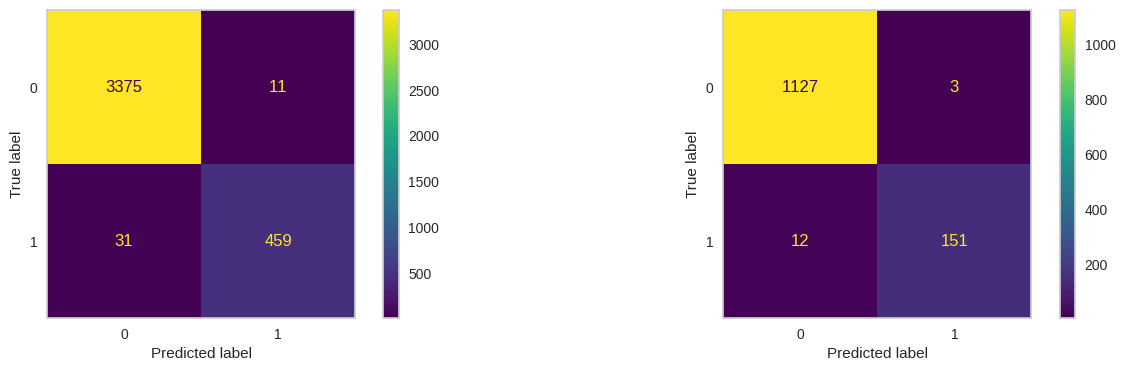

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.989164   0.976596  0.936735  0.956250  0.995348
Test   0.988399   0.980519  0.926380  0.952681  0.997530


In [ ]:
# build model with optimized hyperparameters and run evaluation procedure
sgd_tuned = SGDClassifier(**sgd_study.best_params, random_state=SEED)
evaluate_model(sgd_tuned, X_train, y_train, X_test, y_test, cv=cv)

### Ridge Classifier

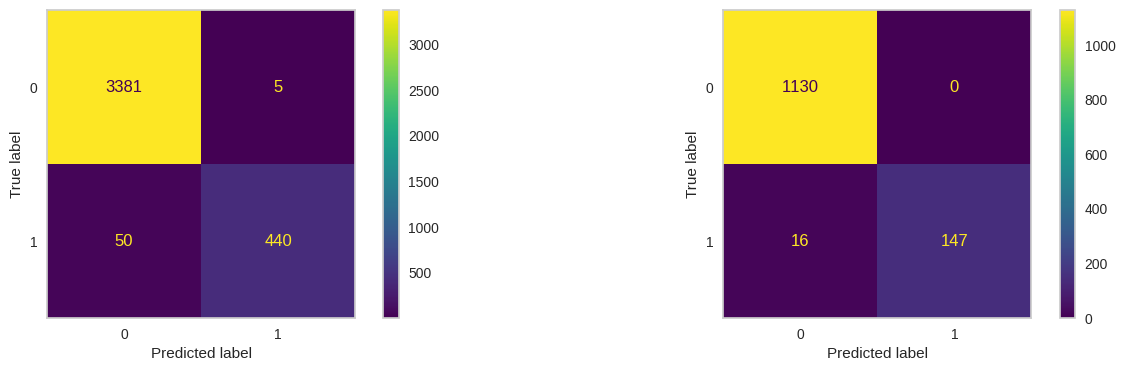

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.985810   0.988764  0.897959  0.941176  0.993603
Test   0.987626   1.000000  0.901840  0.948387  0.998236


In [ ]:
# run evaluation procedure to Ridge classifier from AutoML experiment
ridge = clone(best_models[2])
evaluate_model(ridge, X_train, y_train, X_test, y_test, cv=cv)

In [ ]:
# define objective function for Ridge classifier hyperparameter optimization
def ridge_objective(trial):
  alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
  ridge = RidgeClassifier(alpha=alpha, random_state=SEED)

  # make cross-validated predictions
  preds = cross_val_predict(ridge, X_train, y_train, cv=cv, n_jobs=-1)

  # return cross-validated f1 score
  return f1_score(y_train, preds)

# run optuna optimization
ridge_study = optuna.create_study(direction="maximize")
ridge_study.optimize(ridge_objective, n_trials=100)

[I 2023-07-25 13:53:50,632] A new study created in memory with name: no-name-0c8e9b8b-d576-4e29-931c-4bf11a698f2d
[I 2023-07-25 13:53:51,482] Trial 0 finished with value: 0.8977777777777778 and parameters: {'alpha': 11.642039482886139}. Best is trial 0 with value: 0.8977777777777778.
[I 2023-07-25 13:53:52,390] Trial 1 finished with value: 0.8643678160919541 and parameters: {'alpha': 24.77652781202715}. Best is trial 0 with value: 0.8977777777777778.
[I 2023-07-25 13:53:53,331] Trial 2 finished with value: 0.9458023379383634 and parameters: {'alpha': 0.0005052149639269125}. Best is trial 2 with value: 0.9458023379383634.
[I 2023-07-25 13:53:54,243] Trial 3 finished with value: 0.9411764705882354 and parameters: {'alpha': 1.254470672986547}. Best is trial 2 with value: 0.9458023379383634.
[I 2023-07-25 13:53:54,804] Trial 4 finished with value: 0.863060989643268 and parameters: {'alpha': 25.417480231362575}. Best is trial 2 with value: 0.9458023379383634.
[I 2023-07-25 13:53:55,376] Tri

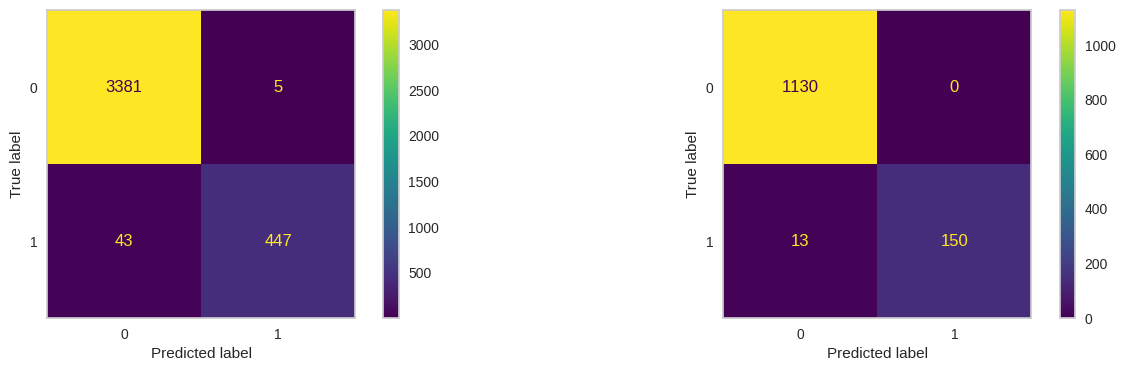

       Accuracy  Precision    Recall  F1 Score   ROC AUC
Train  0.987616   0.988938  0.912245  0.949045  0.993661
Test   0.989946   1.000000  0.920245  0.958466  0.998909


In [ ]:
# build model with optimized hyperparameters and run evaluation procedure
ridge_tuned = RidgeClassifier(**ridge_study.best_params, random_state=SEED)
evaluate_model(ridge_tuned, X_train, y_train, X_test, y_test, cv=cv)

In [ ]:
# function to calculate interest performance metrics for the built models
def metrics(estimator, X_train, y_train, X_test, y_test):
  # fit the estimator
  estimator.fit(X_train, y_train)

  # make predictions in the test set
  preds = estimator.predict(X_test)

  # calculate estimator scores for the test set
  if hasattr(estimator, "predict_proba"):
    scores = estimator.predict_proba(X_test)[:,1]
  elif hasattr(estimator, "decision_function"):
    scores = estimator.decision_function(X_test)

  # calculate classification metrics
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds)
  recall = recall_score(y_test, preds)
  f1 = f1_score(y_test, preds)
  roc = roc_auc_score(y_test, scores)

  return [accuracy, precision, recall, f1, roc]

# build the result metrics table
scores = []
models = [lda, sgd, ridge]
for model in models:
  scores.append(metrics(model, X_train, y_train, X_test, y_test) + ["Before Tuning", model.__class__.__name__])

models = [lda_tuned, sgd_tuned, ridge_tuned]
for model in models:
  scores.append(metrics(model, X_train, y_train, X_test, y_test) + ["After Tuning", model.__class__.__name__])

df_scores = pd.DataFrame(
    data=scores,
    columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Tuning", "Model"],
).set_index(["Model", "Tuning"])

df_scores.sort_values("F1 Score", ascending=False)

Accuracy  Precision    Recall  \
Model                      Tuning                                         
LinearDiscriminantAnalysis Before Tuning  0.990719   1.000000  0.926380   
RidgeClassifier            After Tuning   0.989946   1.000000  0.920245   
SGDClassifier              After Tuning   0.988399   0.980519  0.926380   
                           Before Tuning  0.987626   0.980392  0.920245   
RidgeClassifier            Before Tuning  0.987626   1.000000  0.901840   
LinearDiscriminantAnalysis After Tuning   0.986079   0.967742  0.920245   

                                          F1 Score   ROC AUC  
Model                      Tuning                             
LinearDiscriminantAnalysis Before Tuning  0.961783  0.998388  
RidgeClassifier            After Tuning   0.958466  0.998909  
SGDClassifier              After Tuning   0.952681  0.997530  
                           Before Tuning  0.949367  0.997443  
RidgeClassifier            Before Tuning  0.948387  0.998236  
LinearDiscriminantAnalysis After Tuning   0.943396  0.997975

From all the obtained models, the best one is the **Linear Discriminant Analysis** without hyperparameter tuning. So we will select it to build our final solution pipeline.

# Final Model

Now that we finished the modeling process, it's time to build our final machine learning solution. We need to make our model persistent, allowing it to be used by external applications. In order to do so, it must receive as input the SMS texts and outputs the classification/probabilities.

In [ ]:
# build final machine learning pipeline
sms_spam_clf = Pipeline([
    ("sentence_transformer", sentence_transformer), # previously intantiated sentence transformer
    ("clf", lda) # linear discriminant analysis model without hyperparameter optimization
])

# fit with all available data
sms_spam_clf.fit(X, y)

# serialize and save the pipeline in a file called sms_spam_clf.pkl
with open("sms_spam_clf.pkl", "wb") as f:
  pickle.dump(sms_spam_clf, f)

# Conclusion

The application of machine learning techniques in spam detection on SMS messages may be very effective. By detecting and blocking spam content, mobile providers and applications can mitigate suspicious activities and frauds, improving mobile user experience.

In this project, we were able to build a very effective spam detection solution for SMS messages content, with over **99% of accuracy**.

To improve even more the results of this project, more spam examples could be added to the dataset, reducing the imbalance between the spam and ham.


### External Links and References

[Sentence Transformers Python Package](https://www.sbert.net/)

[Optuna: A hyperparameter optimization framework](https://optuna.readthedocs.io/en/stable/index.html)

[SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

[_scikit-learn_ Machine Learning Library for Python](https://scikit-learn.org/stable/)

Thank you for taking your time to read this notebook.

Feel free to give your feedback and contact me! Also, I would love to connect with you in my social networks!

[![LinkedIn](https://img.shields.io/badge/LinkedIn-igor--trevelin-blue)](https://www.linkedin.com/in/igor-trevelin/)
[![GitHub](https://img.shields.io/badge/GitHub-IgorTrevelin-purple)](https://github.com/IgorTrevelin)